In [1]:
import autograd
import autograd.numpy as np
import autograd.scipy as sp

import VariationalBayes as vb
from copy import deepcopy

import scipy as osp
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:

class Kernel(object):
    def __init__(self, c=1.0, beta=-0.5):
        self.c = c
        self.beta = beta
        
    def k(self, x, y):
        xy_diff = x - y
        return (self.c + np.dot(xy_diff, xy_diff)) ** self.beta

    
class MVNModel(object):
    def __init__(self, obs, obs_info_mat, prior_loc):
        self.prior_loc = deepcopy(prior_loc)
        self.obs_dim = len(obs)
        self.obs = obs
        self.obs_info_mat = deepcopy(obs_info_mat)
        self.prior_info_mat = np.eye(self.obs_dim)

        self.theta = np.zeros(self.obs_dim)
        
    def get_log_post(self, broadcast=False):
        if broadcast:
            obs_centered = np.expand_dims(self.obs, 1) - self.theta
            theta_centered = self.theta - np.expand_dims(self.prior_loc, 1)
        else:
            obs_centered = self.obs - self.theta
            theta_centered = self.theta - self.prior_loc
            
        log_lik =  -0.5 * np.einsum(
            'i...,ij,j...->...',
            obs_centered, self.obs_info_mat, obs_centered)

        log_prior =  -0.5 * np.einsum(
            'i...,ij,j...->...',
            theta_centered, self.prior_info_mat, theta_centered)
        
        return log_lik + log_prior
    
    def get_post_cov(self):
        return np.linalg.inv(self.obs_info_mat + self.prior_info_mat)

    def get_post_mean(self):
        post_cov = self.get_post_cov()
        post_suff_stat = np.matmul(self.obs_info_mat, obs) + \
                         np.matmul(self.prior_info_mat, self.prior_loc)
        return np.matmul(post_cov, post_suff_stat)
    
    def set_theta_get_log_post(self, theta):
        self.theta = theta
        return self.get_log_post()



In [3]:
obs_dim = 2
obs = np.array([0.2, 0.5])
obs_info_mat = 30 * np.eye(obs_dim)
prior_loc = np.zeros(obs_dim)
theta = np.full(obs_dim, 0.2)

mvn_model = MVNModel(obs, obs_info_mat, prior_loc)
print(mvn_model.get_post_mean())
print(obs)



[ 0.19354839  0.48387097]
[ 0.2  0.5]


In [4]:
num_draws = 30
theta_draws = osp.stats.multivariate_normal.rvs(
    size=num_draws, mean=mvn_model.get_post_mean(), cov=mvn_model.get_post_cov())
print(theta_draws.shape)

theta_mean = np.mean(theta_draws, axis=0)
theta_sd = np.std(theta_draws, axis=0)
theta_se = theta_sd / np.sqrt(num_draws)

(30, 2)


In [10]:
class SteinGradientGenerator(object):
    def __init__(self, mvn_model):
        self.mvn_model = deepcopy(mvn_model)
        self.get_log_post_grad = autograd.grad(self.mvn_model.set_theta_get_log_post)
        self.kernel = Kernel()
        self.get_kernel_grad = autograd.grad(self.kernel.k, argnum=0)

    def get_kernel_mat(self, theta_draws):
        return np.array([[ self.kernel.k(t1, t2) for t2 in theta_draws] for t1 in theta_draws])
    
    def get_kernel_grad_mat(self, theta_draws):
        # t1 is in the first index; it is this that we need to sum out for the gradient step.
        return np.array([[ self.get_kernel_grad(t1, t2) for t2 in theta_draws] \
                           for t1 in theta_draws])

    def get_post_grads(self, theta_draws):
        return np.array([ self.get_log_post_grad(theta) for theta in theta_draws ])
    
    def get_stein_grad_term(self, theta_draws):
        kernel_mat = self.get_kernel_mat(theta_draws)
        post_grads = self.get_post_grads(theta_draws)
        num_draws = theta_draws.shape[0]
        return np.einsum('ij,jk->ik', kernel_mat, post_grads) / num_draws
    
    def get_stein_kernel_term(self, theta_draws):
        num_draws = theta_draws.shape[0]
        kernel_grad_mat = self.get_kernel_grad_mat(theta_draws)
        return np.sum(kernel_grad_mat, axis=0) / num_draws
    
    def get_stein_direction(self, theta_draws):
        return self.get_stein_grad_term(theta_draws) + self.get_stein_kernel_term(theta_draws)

In [11]:
stein_gradient_generator = SteinGradientGenerator(mvn_model)

def get_stein_direction(stein_gradient_generator, theta_draws):
    stein_grad_term = stein_gradient_generator.get_stein_grad_term(theta_draws)
    stein_kernel_term = stein_gradient_generator.get_stein_kernel_term(theta_draws)
    stein_direction = stein_gradient_generator.get_stein_direction(theta_draws)
    
    return stein_direction

def get_stein_step(stein_gradient_generator, theta_draws, start_scale=1.0):
    stein_direction = get_stein_direction(stein_gradient_generator, theta_draws)

    grad_mag = np.linalg.norm(stein_direction)
    grad_mag_diff = np.float('inf')
    scale = start_scale
    while grad_mag_diff > 0.:
        theta_update = theta_draws + scale * stein_direction
        new_direction = get_stein_direction(stein_gradient_generator, theta_update)
        new_grad_mag = np.linalg.norm(new_direction)
        grad_mag_diff = new_grad_mag - grad_mag
        if grad_mag_diff >= 0.:
            scale *= 0.5
            print('Difference: ', grad_mag_diff, ' decreasing scale to ', scale)
        else:
            print('Accepting step from ', grad_mag, ' to ', new_grad_mag)

    return theta_update, stein_direction, scale


In [12]:

true_mean = mvn_model.get_post_mean()
theta_draws = osp.stats.multivariate_normal.rvs(
    size=50,
    mean=mvn_model.get_post_mean(),
    cov=mvn_model.get_post_cov())
init_theta_draws = deepcopy(theta_draws)

theta_sd = np.std(theta_draws, axis=0)
num_draws = theta_draws.shape[0]
theta_se = theta_sd / np.sqrt(num_draws)

# This is the step size that changes the mean by no more than one
# a standard error.
theta_draws, stein_direction, last_scale = \
    get_stein_step(stein_gradient_generator, theta_draws, start_scale=1.0)
last_scale = np.min(theta_se / np.abs(np.mean(stein_direction, axis=0)))

for step in range(20):
    theta_draws, stein_direction, last_scale = \
        get_stein_step(stein_gradient_generator, theta_draws, start_scale=1.5 * last_scale)
    print(np.linalg.norm(stein_direction))

print('Done.')



Difference:  37.1703636131  decreasing scale to  0.5
Difference:  17.3040479533  decreasing scale to  0.25
Difference:  7.30588839309  decreasing scale to  0.125
Difference:  2.29278582575  decreasing scale to  0.0625
Accepting step from  1.37402211972  to  1.16398769828
Difference:  5.04390553149  decreasing scale to  0.108243638079
Difference:  1.37082034563  decreasing scale to  0.0541218190394
Accepting step from  1.16398769828  to  0.707749893272
1.16398769828
Difference:  0.265199641349  decreasing scale to  0.0405913642795
Accepting step from  0.707749893272  to  0.202750551777
0.707749893272
Accepting step from  0.202750551777  to  0.17753958704
0.202750551777
Difference:  0.0457921856912  decreasing scale to  0.0456652848145
Accepting step from  0.17753958704  to  0.138126430033
0.17753958704
Accepting step from  0.138126430033  to  0.12886300579
0.138126430033
Difference:  0.0056290105247  decreasing scale to  0.0513734454163
Accepting step from  0.12886300579  to  0.11779162

[[ 0.02756143 -0.00135533]
 [-0.00135533  0.02890398]] 
-----
 [[  3.15714089e-02   8.30317292e-06]
 [  8.30317292e-06   3.22490134e-02]] 
-----
 [[ 0.03225806  0.        ]
 [ 0.          0.03225806]]





[ 0.19613355  0.48903547] 
-----
 [ 0.1928177   0.48346379] 
-----
 [ 0.19354839  0.48387097]


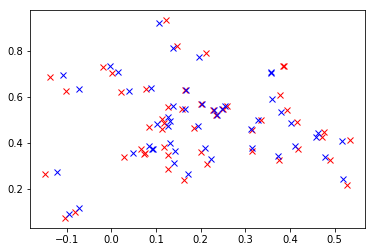

In [14]:
print(np.cov(np.transpose(init_theta_draws)), '\n-----\n',
      np.cov(np.transpose(theta_draws)), '\n-----\n',
      mvn_model.get_post_cov())

print('\n\n\n\n')
print(np.mean(init_theta_draws, axis=0), '\n-----\n',
      np.mean(theta_draws, axis=0), '\n-----\n',
      mvn_model.get_post_mean())

plt.plot(theta_draws[:, 0], theta_draws[:, 1], 'rx')
plt.plot(init_theta_draws[:, 0], init_theta_draws[:, 1], 'bx')


In [15]:
prior_loc_pert = deepcopy(prior_loc)
prior_loc_pert[0] += 3
mvn_model_pert = MVNModel(obs, obs_info_mat, prior_loc_pert)
theta_draws_pert = deepcopy(theta_draws)

print(mvn_model_pert.get_post_mean() - mvn_model.get_post_mean())


[ 0.09677419  0.        ]


In [22]:
stein_gradient_generator_pert = SteinGradientGenerator(mvn_model_pert)

last_scale = 1.0
max_iter = 50
i = 0
grad_norm = float('inf')
while i < max_iter and grad_norm > 0.1:
    theta_draws_pert, stein_direction, last_scale = \
        get_stein_step(stein_gradient_generator_pert, theta_draws_pert, start_scale=last_scale)
    grad_norm = np.linalg.norm(stein_direction)
    i = i + 1
    print('Iter {}: {}'.format(i, grad_norm))

print('Done.')



Difference:  14.9759417276  decreasing scale to  0.5
Difference:  6.94036824134  decreasing scale to  0.25
Difference:  2.92167158261  decreasing scale to  0.125
Difference:  0.912301846754  decreasing scale to  0.0625
Accepting step from  0.549601808106  to  0.458050301563
Iter 1: 0.5496018081062204
Accepting step from  0.458050301563  to  0.383853612898
Iter 2: 0.4580503015632005
Accepting step from  0.383853612898  to  0.319878651751
Iter 3: 0.3838536128975147
Accepting step from  0.319878651751  to  0.268670186553
Iter 4: 0.3198786517506675
Accepting step from  0.268670186553  to  0.223985018687
Iter 5: 0.26867018655306957
Accepting step from  0.223985018687  to  0.188845768783
Iter 6: 0.22398501868735943
Accepting step from  0.188845768783  to  0.157689457753
Iter 7: 0.18884576878346918
Accepting step from  0.157689457753  to  0.133806939566
Iter 8: 0.15768945775269907
Accepting step from  0.133806939566  to  0.112183651375
Iter 9: 0.13380693956619488
Accepting step from  0.112183

KeyboardInterrupt: 

[ 0.09677419  0.        ]
[ 0.09709597  0.000321  ]


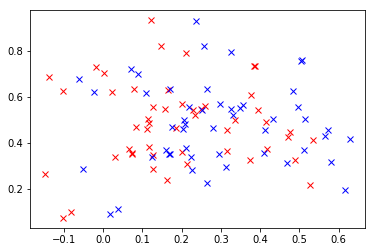

In [24]:
print(mvn_model_pert.get_post_mean() - mvn_model.get_post_mean())
print(np.mean(theta_draws_pert, axis=0) - np.mean(theta_draws, axis=0))

plt.plot(theta_draws[:, 0], theta_draws[:, 1], 'rx')
plt.plot(theta_draws_pert[:, 0], theta_draws_pert[:, 1], 'bx')
